<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12회차: RNN을 활용한 항공 여행자 수 예측 (2) - 데이터 전처리 및 분석

## MinMax 데이터 정규화

In [1]:
# 운영체제 경로, 파일 조작 등을 위한 표준 라이브러리
import os
# 데이터프레임 형태로 데이터 처리 (엑셀/CSV 등 표 형식 데이터 분석)
import pandas as pd
# 수치 계산, 배열 연산 등을 위한 과학 계산 라이브러리
import numpy as np
# 딥러닝 모델 구성 및 학습을 위한 프레임워크 (RNN, LSTM 등 사용 가능)
import tensorflow as tf
# KaggleHub에서 공개 데이터셋을 다운로드할 수 있는 유틸리티
import kagglehub
# 데이터 시각화를 위한 기본 그래프 라이브러리
import matplotlib.pyplot as plt
# 데이터 정규화를 위한 전처리 도구 (예: 0~1 사이로 MinMax 스케일링)
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 1. 데이터 로드 및 전처리

# KaggleHub에서 "AirPassengers" 시계열 데이터셋을 다운로드
# 데이터셋 ID: pattnaiksatyajit/air-passengers
path = kagglehub.dataset_download("pattnaiksatyajit/air-passengers")
# 다운로드한 경로에서 'AirPassengers.csv' 파일 경로 생성
csv_file_path = os.path.join(path, "AirPassengers.csv")
# CSV 파일을 판다스 DataFrame으로 읽어오기
df = pd.read_csv(csv_file_path)
# DataFrame 구조 및 열 정보 출력 (결측값, 타입, 행 수 확인용)
df.info()

100%|██████████| 764/764 [00:00<00:00, 1.35MB/s]

Extracting files...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
# 문자열 형식의 'Month' 열을 pandas의 datetime 타입으로 변환
# 예: '1949-01' → Timestamp('1949-01-01 00:00:00')
df['Month'] = pd.to_datetime(df['Month'])

# 'Month' 열을 DataFrame의 인덱스로 설정
# 시간 순서 기반 시계열 분석, 시각화 등에 유리하게 만듦
# inplace=True → 원본 df를 바로 수정
df.set_index('Month', inplace=True)

# DataFrame의 구조, 열 이름, 결측값, 데이터 타입, 메모리 사용량 등을 출력
# → 데이터 확인의 첫 단계로 자주 사용함
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [21]:
# 데이터 정규화를 위한 전처리 도구 (예: 0~1 사이로 MinMax 스케일링)
from sklearn.preprocessing import MinMaxScaler

# -------------------------------------------------------------
# 2. MinMax Scaling 적용
#    '#Passengers' 열을 0~1 범위로 정규화
# -------------------------------------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['#Passengers']])  # 결과는 numpy array

# -------------------------------------------------------------
# 원본 값에서 최소/최대값의 "정수형 위치 인덱스" 추출
#    idxmin(): 최소값의 시계열 인덱스 → get_loc(): 정수형 위치로 변환
# -------------------------------------------------------------
psg = df['#Passengers']
idx_min = psg.index.get_loc(psg.idxmin())  # 예: 10
idx_max = psg.index.get_loc(psg.idxmax())  # 예: 138

# -------------------------------------------------------------
# 결과 출력: 원본 범위 vs 스케일링 결과 확인
# -------------------------------------------------------------
print("최소값 위치 인덱스:", idx_min)
print("최대값 위치 인덱스:", idx_max)
print("원본 최소/최대값:", psg.min(), psg.max()) # 104, 622

print("스케일링된 데이터 타입과 크기:", type(scaled_data), scaled_data.shape)
print("스케일링된 최소/최대값:", scaled_data.min().item(), scaled_data.max().item())

최소값 위치 인덱스: 10
최대값 위치 인덱스: 138
원본 최소/최대값: 104 622
스케일링된 데이터 타입과 크기: <class 'numpy.ndarray'> (144, 1)
스케일링된 최소/최대값: 0.0 1.0


In [20]:
psg.idxmin() # 결과는 현재 인데스인 Timestamp

Timestamp('1949-11-01 00:00:00')

In [22]:
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

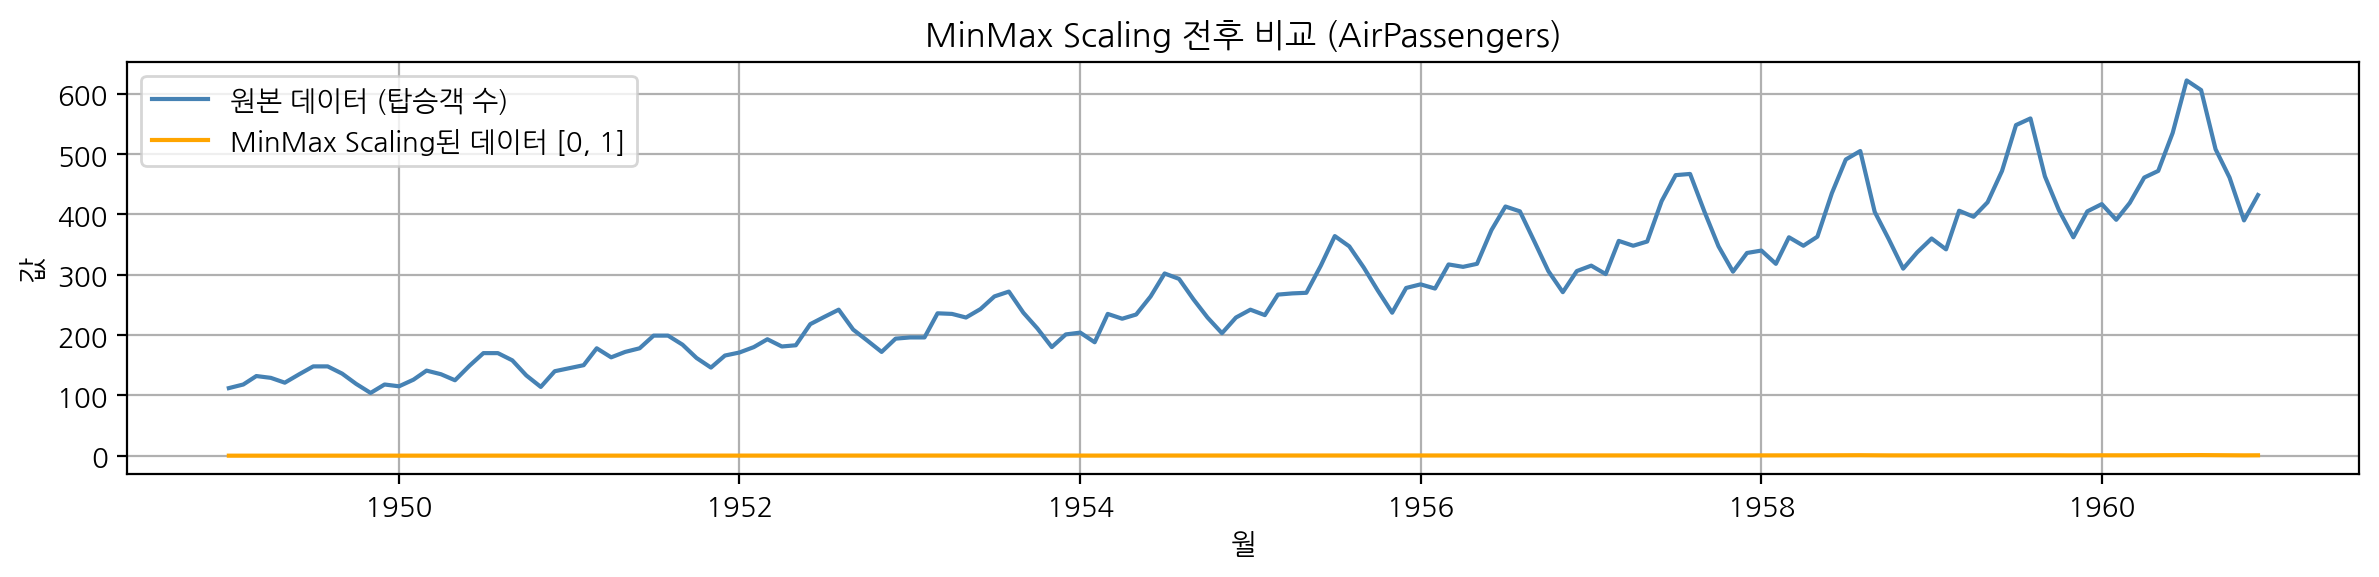

In [23]:
# 스케일된 결과를 Pandas Series로 변환하여 시계열 인덱스(df.index)와 매칭
# flatten() → (144, 1) 형태의 array를 (144,) 1차원으로 펴줌
scaled_series = pd.Series(scaled_data.flatten(), index=df.index)

# 시각화 시작: 원본 vs 스케일링 결과 비교
plt.figure(figsize=(12, 3))  # 가로 12인치, 세로 3인치 크기의 그래프 생성

# 원본 데이터 선 그래프: 파란색, 실제 탑승객 수
plt.plot(df.index, df['#Passengers'], label='원본 데이터 (탑승객 수)', color='steelblue')
# 정규화된 데이터 선 그래프: 주황색, 0~1 사이 값
plt.plot(df.index, scaled_series, label='MinMax Scaling된 데이터 [0, 1]', color='orange')

# 그래프 제목 및 축 레이블 설정
plt.title("MinMax Scaling 전후 비교 (AirPassengers)")
plt.xlabel("월")           # X축: 월(시계열)
plt.ylabel("값")           # Y축: 값 (탑승객 수 또는 정규화된 수치)

# 범례 표시 및 격자 추가
plt.legend()
plt.grid(True)
# 레이아웃 자동 정리 및 시각화 출력
plt.tight_layout()
plt.show()

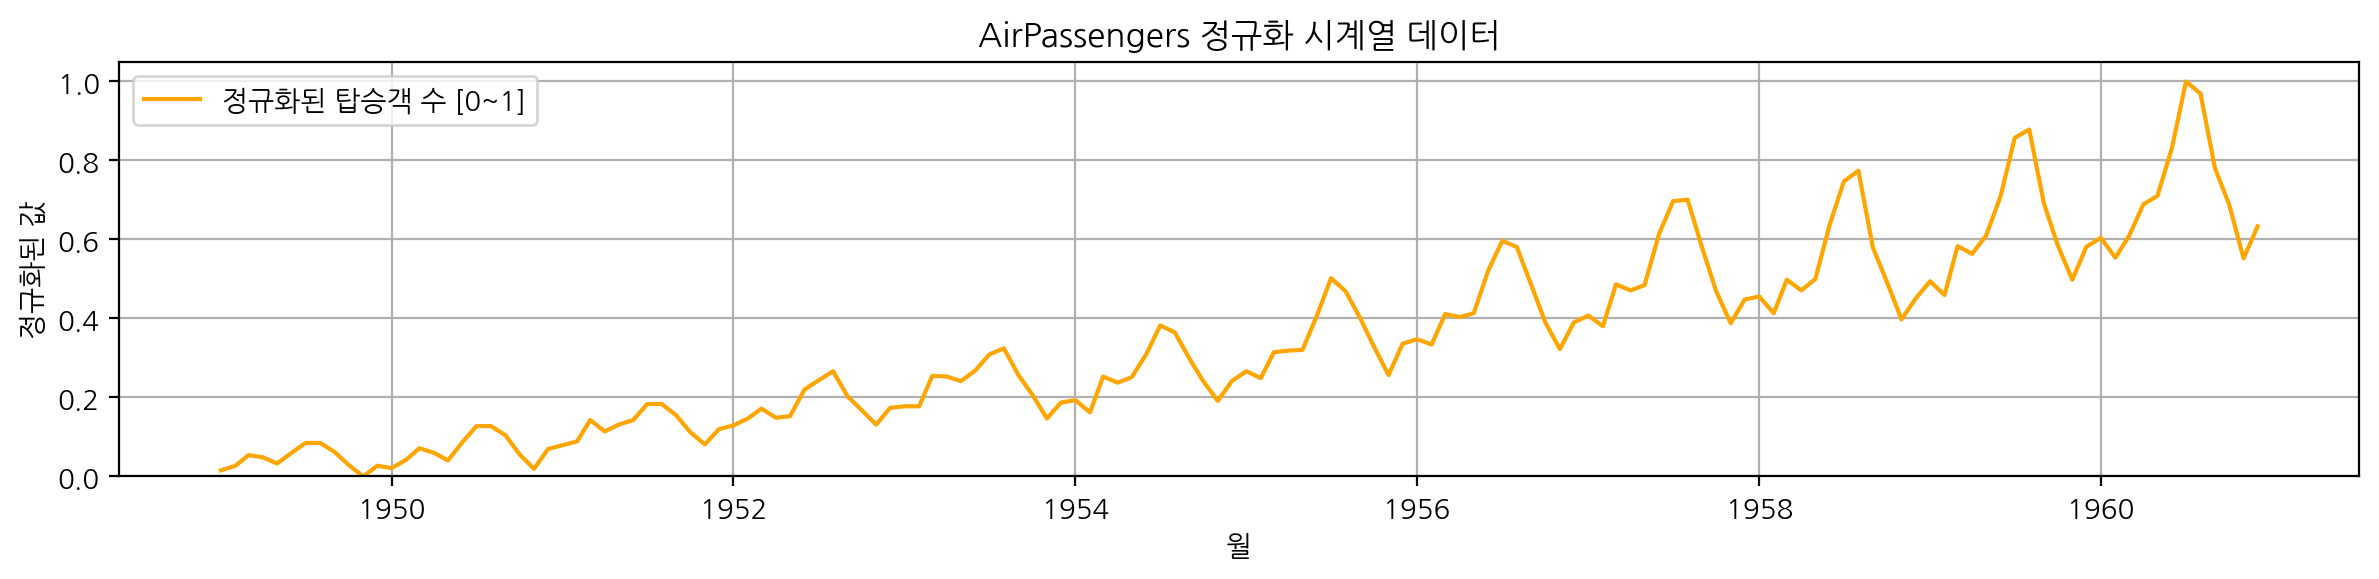

In [24]:
# 정규화된 값을 시계열 인덱스와 함께 Series로 변환
scaled_series = pd.Series(scaled_data.flatten(), index=df.index)

# 정규화된 값만 시각화
plt.figure(figsize=(12, 3))
plt.plot(scaled_series, color='orange', label='정규화된 탑승객 수 [0~1]')
plt.title("AirPassengers 정규화 시계열 데이터")
plt.xlabel("월")
plt.ylabel("정규화된 값")
plt.ylim(0, 1.05)  # y축 범위를 명확히 0~1로 지정
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Airpassengers 데이터 사분할

In [10]:
# 3. Sliding Window 시퀀스 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X_all, y_all = create_sequences(scaled_data, SEQ_LENGTH)
X_all.shape, y_all.shape

((132, 12, 1), (132, 1))

In [12]:
scaled_data[:13]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552]])

In [13]:
X_all[0], y_all[0]

(array([[0.01544402],
        [0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984556],
        [0.08494208],
        [0.08494208],
        [0.06177606],
        [0.02895753],
        [0.        ],
        [0.02702703]]),
 array([0.02123552]))

In [14]:
# 4. 시간 순서 유지하며 Train/Val/Test 분할

# 전체 시퀀스 개수 확인 (Sliding Window로 생성된 샘플 수)
n = len(X_all)
# 훈련 데이터 종료 인덱스: 전체의 70% 지점
train_end = int(n * 0.7)
# 검증 데이터 종료 인덱스: 전체의 85% 지점
val_end = int(n * 0.85)

# 훈련 세트: 시계열 앞부분 70%
X_train, y_train = X_all[:train_end], y_all[:train_end]
# 검증 세트: 다음 15% (하이퍼파라미터 튜닝용)
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
# 테스트 세트: 가장 마지막 15% (모델 성능 평가용)
X_test, y_test = X_all[val_end:], y_all[val_end:]
# 각 세트의 입력 시퀀스(shape: 샘플 수, 시퀀스 길이, 피처 수) 출력
print(X_train.shape, X_val.shape, X_test.shape)
# 각 세트의 정답 벡터(shape: 샘플 수,) 출력
print(y_train.shape, y_val.shape, y_test.shape)

(92, 12, 1) (20, 12, 1) (20, 12, 1)
(92, 1) (20, 1) (20, 1)


## 13회차 나머지 코드

Epoch  10 - loss: 0.0011, val_loss: 0.0023
Epoch  20 - loss: 0.0008, val_loss: 0.0018
Epoch  30 - loss: 0.0007, val_loss: 0.0014
Epoch  40 - loss: 0.0006, val_loss: 0.0013
Epoch  50 - loss: 0.0006, val_loss: 0.0015
Epoch  60 - loss: 0.0006, val_loss: 0.0014
Epoch  70 - loss: 0.0005, val_loss: 0.0013
Epoch  80 - loss: 0.0006, val_loss: 0.0015
Epoch  90 - loss: 0.0005, val_loss: 0.0018
Epoch 100 - loss: 0.0008, val_loss: 0.0012
Epoch 110 - loss: 0.0005, val_loss: 0.0016
Epoch 120 - loss: 0.0006, val_loss: 0.0014
Epoch 130 - loss: 0.0005, val_loss: 0.0012
Epoch 140 - loss: 0.0006, val_loss: 0.0016
Epoch 150 - loss: 0.0005, val_loss: 0.0013
Epoch 160 - loss: 0.0005, val_loss: 0.0014
Epoch 170 - loss: 0.0005, val_loss: 0.0013
Epoch 180 - loss: 0.0006, val_loss: 0.0024
Epoch 190 - loss: 0.0005, val_loss: 0.0020
Epoch 200 - loss: 0.0005, val_loss: 0.0012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


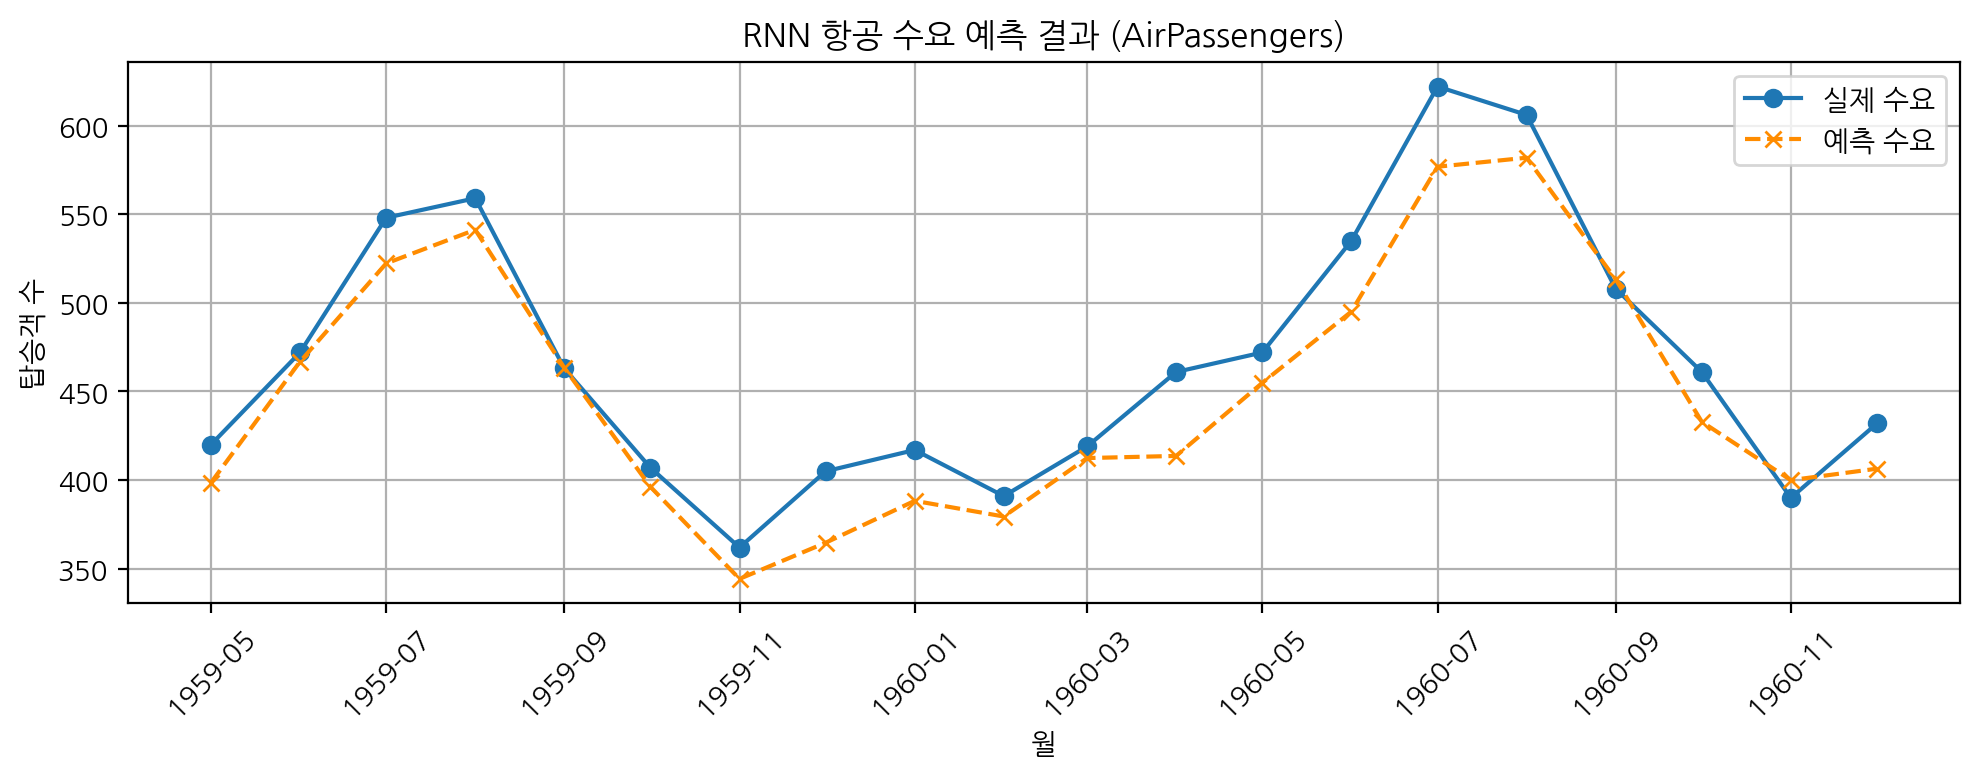

In [ ]:
# 5. RNN 모델 정의
model = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.SimpleRNN(64, activation='tanh'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 6. 10 에폭마다 로그 출력 콜백
class PrintEvery10Epochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} - loss: {logs['loss']:.4f}, val_loss: {logs['val_loss']:.4f}")

# 7. 모델 학습
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    verbose=0,
    callbacks=[PrintEvery10Epochs()]
)

# 8. 예측 및 시각화
predicted = model.predict(X_test)
predicted_inverse = scaler.inverse_transform(predicted)
y_test_inverse = scaler.inverse_transform(y_test)

# 테스트 시점의 날짜 복원
dates = df.index[SEQ_LENGTH + val_end : SEQ_LENGTH + val_end + len(y_test)]

plt.figure(figsize=(10, 4))
plt.plot(dates, y_test_inverse, 'o-', label='실제 수요')
plt.plot(dates, predicted_inverse, 'x--', label='예측 수요', color='darkorange')
plt.title("RNN 항공 수요 예측 결과 (AirPassengers)")
plt.xlabel("월")
plt.ylabel("탑승객 수")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 종료